# Class ACtivation Map

이번 실습에서는 pretrained MobileNet을 이용하여 Class Activation Map을 구해보겠습니다.

In [1]:
## Google Drive 연동
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
## Google Colab에서 TensorFlow 2.x 버전을 사용하기 위해서는 아래 magic command를 수행하면 간편하게 할 수 있습니다

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [9]:
## 필요한 Library들을 import 합니다
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

## TensorFlow, Keras version 확인
print(tf.__version__)
print(keras.__version__)

2.1.0
2.2.4-tf


## Inference Test

In [0]:
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input, decode_predictions

In [0]:
IMG_SIZE = 224

In [5]:
## Pretrained MobileNet 가져오기
mobilenet = MobileNet(weights='imagenet', include_top=True, input_shape=(IMG_SIZE, IMG_SIZE, 3))
mobilenet.trainable = False

17227776/17225924 [==============================] - 0s 0us/step


In [6]:
## Google Drive로 이동
cd '/content/drive/My Drive/TensorFlow_Training_15th'

/content/drive/My Drive/TensorFlow_Training_15th


In [10]:
## Test image 열기
from PIL import Image
test_img = Image.open('data/guitar.jpg')
test_img = test_img.resize((IMG_SIZE, IMG_SIZE))
test_img = np.asarray(test_img)
test_img = np.reshape(test_img, (-1, IMG_SIZE, IMG_SIZE, 3))
test_img.shape

(1, 224, 224, 3)

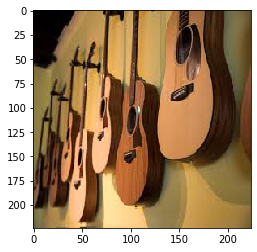

In [11]:
## image 확인
plt.imshow(test_img[0])
plt.show()

In [0]:
## MobileNet으로 inference하기
prediction = mobilenet.predict(preprocess_input(test_img))

In [15]:
## 예측결과확인
np.argmax(prediction)

402

In [16]:
decode_predictions(prediction, top=5)

40960/35363 [==================================] - 0s 0us/step


[[('n02676566', 'acoustic_guitar', 0.5215823),
  ('n02992211', 'cello', 0.27240372),
  ('n03272010', 'electric_guitar', 0.10318701),
  ('n04208210', 'shovel', 0.046063133),
  ('n04536866', 'violin', 0.017287519)]]

## Class Activation Map

In [18]:
mobilenet.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [0]:
## input image를 받아서, 마지막 feature map을 출력해주는 model 생성
target_fmap = mobilenet.get_layer(name='conv_pw_13_relu').output
model = keras.models.Model(mobilenet.input, target_fmap)

In [20]:
## fully connected layer의 weight
weights = mobilenet.get_layer(name='conv_preds').get_weights()[0]
print(weights.shape)

(1, 1, 1024, 1000)


In [21]:
## weight reshape
weights = np.reshape(weights, (1024, 1000))
print(weights.shape)

(1024, 1000)


In [23]:
## test image를 읽어와서 224, 224로 resize
cur_dir = os.getcwd()
img_path = os.path.join(cur_dir, 'data', 'catdog.jpg')
currimg = Image.open(img_path)
currimg = currimg.resize((IMG_SIZE, IMG_SIZE))
image = np.asarray(currimg)
image = np.reshape(image, (-1, IMG_SIZE, IMG_SIZE, 3))
print(image.shape)

(1, 224, 224, 3)


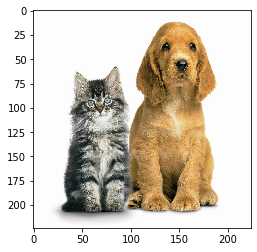

In [24]:
## image 확인
plt.imshow(image[0])
plt.show()

In [25]:
## test image를 pretrained model에 넣고 feature map을 뽑음
fmap = model(preprocess_input(image))
fmap = np.reshape(np.array(fmap), (7,7,1024))
print(fmap.shape)

(7, 7, 1024)


In [26]:
## test image에 대한 top-1 class 확인
prediction = mobilenet.predict(preprocess_input(image))

pred_class = np.argmax(prediction, -1)
pred_class

array([539])

In [27]:
## top-1 외에 다른 class에 대한 label에 대해서도 CAM을 수행할 수 있도록 label list 생성
label_list = np.argsort(prediction, -1)
label_list = label_list[0, ::-1]
label_list[0]

539

In [28]:
## top 3 label 확인
label_list[2]

281

In [29]:
## top-5 확인
decode_predictions(prediction, top=5)

[[('n03223299', 'doormat', 0.34161642),
  ('n02100583', 'vizsla', 0.13030733),
  ('n02123045', 'tabby', 0.11734222),
  ('n04118776', 'rule', 0.028713103),
  ('n04317175', 'stethoscope', 0.024227373)]]

In [30]:
## top-5 class중 원하는 class에 대한 weight 가져오기
## 예) top-1 class: label_list[0], top-2 class: label_list[1], ...
#weights_cam = weights[:, pred_class[0]]
weights_cam = weights[:, label_list[2]]
weights_cam.shape

(1024,)

In [0]:
## CAM 만들기 (0으로 초기화한 후 weight x feature map을 누적해서 더함)
camsum = np.zeros((7,7))
for i in range(1024):
    camsum = camsum + weights_cam[i]*fmap[:,:,i]
camsum = camsum / 1024.

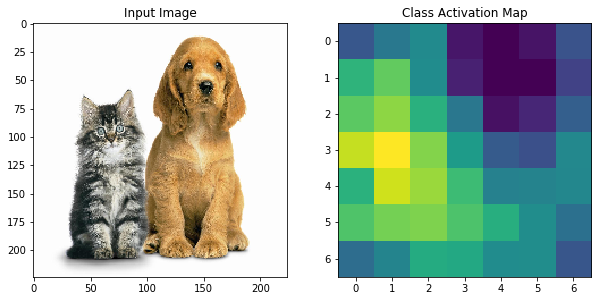

In [32]:
## 원본 image와 CAM 확인
fig1 = plt.figure(figsize=(10,6))
ax1 = fig1.add_subplot(1,2,1)
ax1.imshow(image[0])
ax1.set_title("Input Image")
ax2 = fig1.add_subplot(1,2,2)
ax2.imshow(camsum)
ax2.set_title("Class Activation Map")
plt.show()